In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
#download the edited file
df = pd.read_json('BITFINEX/IOTUSD_EDA.json')
df.reset_index(inplace=True)
df = df.rename(columns={'index':'Date'})
print(df.head())

        Date     High      Low       Mid     Last      Bid      Ask  \
0 2017-06-13  1.30000  0.41000  0.595810  0.59773  0.59400  0.59762   
1 2017-06-14  0.61010  0.47948  0.509245  0.50639  0.50639  0.51210   
2 2017-06-15  0.54470  0.29123  0.367650  0.36600  0.36600  0.36930   
3 2017-06-16  0.59900  0.30530  0.415355  0.41540  0.41531  0.41540   
4 2017-06-17  0.45116  0.39000  0.432555  0.43210  0.43210  0.43301   

      Volume  Year  Month  Day    Weekday  
0  16.000992    17      6   13    Tuesday  
1  15.950432    17      6   14  Wednesday  
2  15.675398    17      6   15   Thursday  
3  15.422886    17      6   16     Friday  
4  14.310691    17      6   17   Saturday  


Goals for preprocessing:
-dummy
-scale
-split

In [3]:
X = df.drop(columns=['Date', 'Weekday', 'Last'])
y = df['Last']

In [4]:
################################################

train_indices = []
test_indices = []

tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)
    
X_train_0 = X.iloc[train_indices[0]]
X_train_1 = X.iloc[train_indices[1]]
X_train_2 = X.iloc[train_indices[2]]
X_train_3 = X.iloc[train_indices[3]]
X_train_4 = X.iloc[train_indices[4]]

X_test_0 = X.iloc[test_indices[0]]
X_test_1 = X.iloc[test_indices[1]]
X_test_2 = X.iloc[test_indices[2]]
X_test_3 = X.iloc[test_indices[3]]
X_test_4 = X.iloc[test_indices[4]]

y_train_0 = y.iloc[train_indices[0]]
y_train_1 = y.iloc[train_indices[1]]
y_train_2 = y.iloc[train_indices[2]]
y_train_3 = y.iloc[train_indices[3]]
y_train_4 = y.iloc[train_indices[4]]

y_test_0 = y.iloc[test_indices[0]]
y_test_1 = y.iloc[test_indices[1]]
y_test_2 = y.iloc[test_indices[2]]
y_test_3 = y.iloc[test_indices[3]]
y_test_4 = y.iloc[test_indices[4]]

Goals for modeling:
-pick 2 models to use (linear regression and arima, ridge or lasso?)
-train, test, review, select best model

In [5]:
def cross_validation(model, X, y, n, score_func):
    cv = TimeSeriesSplit(n_splits=n)
    result = cross_val_score(model, X, y, scoring=make_scorer(score_func), cv=cv)

In [6]:
#linear regression model
max_iterations = range(0, 5)

for i in tqdm(max_iterations):
    X_train = X.iloc[train_indices[i]]
    X_test = X.iloc[test_indices[i]]
    y_train = y.iloc[train_indices[i]]
    y_test = y.iloc[test_indices[i]]
    lr = LinearRegression().fit(X_train, y_train)
    print(lr.score(X_test, y_test))

#print(cross_validation(lr, X, y, 5, precision_score))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.40it/s]

0.9999913865717602
0.9999656669939508
0.9999393636378607
0.9999433985216021
0.9999907800788486


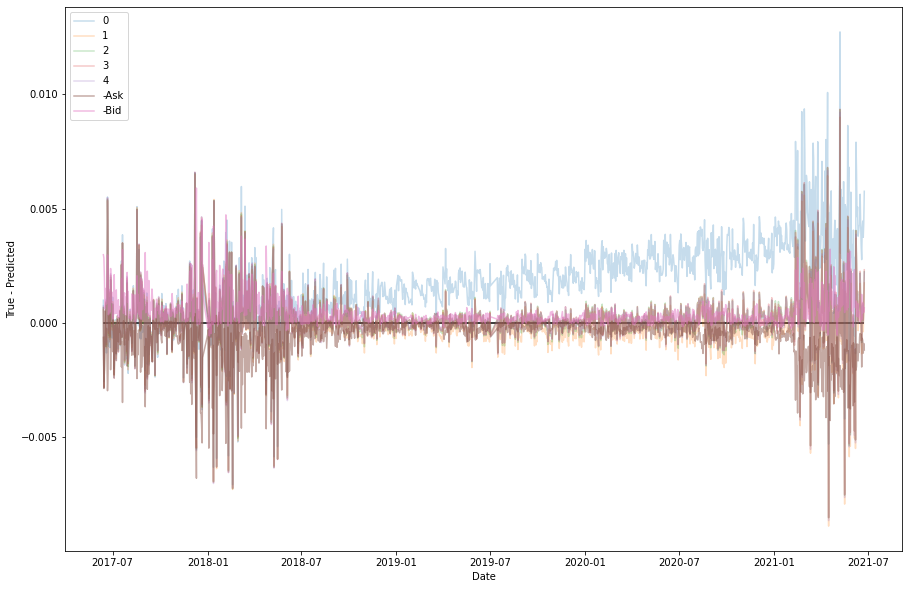

In [54]:
#need to have a graphable forcast for linear regression


plt.figure(figsize=(15, 10))

for i in range(0, 5):
    lr.fit(X.iloc[train_indices[i]], y.iloc[train_indices[i]])
    y_predictions = lr.predict(X)
    plt.plot(df['Date'], y-y_predictions, label = i, alpha=0.25)
#plt.plot(df['Date'], y_predictions, label='Predicted', alpha=0.25)

plt.plot(df['Date'], y_predictions-df['Ask'], label='-Ask', alpha=0.5)
plt.plot(df['Date'], y_predictions-df['Bid'], label='-Bid', alpha=0.5)
plt.hlines(y=0, xmin=df['Date'].iloc[0], xmax=df['Date'].iloc[-1])
plt.xlabel('Date')
plt.ylabel('True - Predicted')
plt.legend()
plt.show()